In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib import parse
import requests
from PIL import Image

from tqdm import tqdm_notebook
import selenium
import nltk
import seaborn as sns
from tensorflow.keras import preprocessing
from wordcloud import WordCloud, STOPWORDS
from eunjeon import Mecab

import matplotlib.pyplot as plt
%matplotlib inline

## - 데이터 불러오기 및 분석하기

In [2]:
import re
import json
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

df_union = pd.read_csv('./data/dc_db.csv', sep=',', encoding='utf-8', index_col=0)
df_union.head()

,gall_name,cmt_contents,label
0,baseball_new8,ㅠ.ㅠ,0
1,baseball_new8,댓글 지우지?,0
2,baseball_new8,ㅋㅋ,0
3,baseball_new8,설렁설렁해라 - dc App,0
4,baseball_new8,Bcaa함 묵으라,0


In [3]:
print('전체 데이터 개수 : ', len(df_union))

전체 데이터 개수 :  9288


In [4]:
cmt_length = df_union['cmt_contents'].astype(str).apply(len)
cmt_length.head(20)

0      3
1      7
2      2
3     16
4      9
5      4
6     15
7     23
8     11
9     24
10    24
11    17
12     8
13    18
14    14
15     4
16    10
17     2
18     2
19     3
Name: cmt_contents, dtype: int64

Text(0, 0.5, 'Number of review')

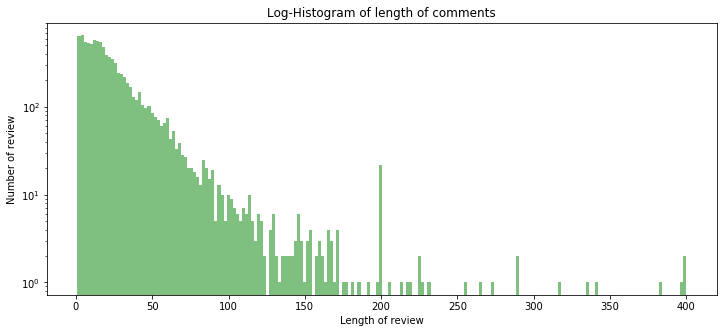

In [5]:
# 그래프
plt.figure(figsize=(12,5))
plt.hist(cmt_length, bins=200, alpha=0.5, color='g', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of comments')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

In [6]:
print('댓글 길이 최댓값 ', np.max(cmt_length))
print('댓글 길이 최솟값 ', np.min(cmt_length))
print('댓글 길이 평균값 ', np.mean(cmt_length))
print('댓글 길이 표준편차 ', np.std(cmt_length))
print('댓글 길이 중간값 ', np.median(cmt_length))
print('댓글 길이 제1사분위 ', np.percentile(cmt_length, 25))
print('댓글 길이 제3사분위 ', np.percentile(cmt_length, 75))

댓글 길이 최댓값  400
댓글 길이 최솟값  1
댓글 길이 평균값  24.163113695090438
댓글 길이 표준편차  27.279082661558686
댓글 길이 중간값  17.0
댓글 길이 제1사분위  8.0
댓글 길이 제3사분위  30.0


{'whiskers': [<matplotlib.lines.Line2D at 0x17eec355c18>,
 'caps': [<matplotlib.lines.Line2D at 0x17eec35f358>,
 'boxes': [<matplotlib.lines.Line2D at 0x17eec355ac8>],
 'medians': [<matplotlib.lines.Line2D at 0x17eec35f9e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x17eec36a080>],
 'means': [<matplotlib.lines.Line2D at 0x17eec35fd30>]}

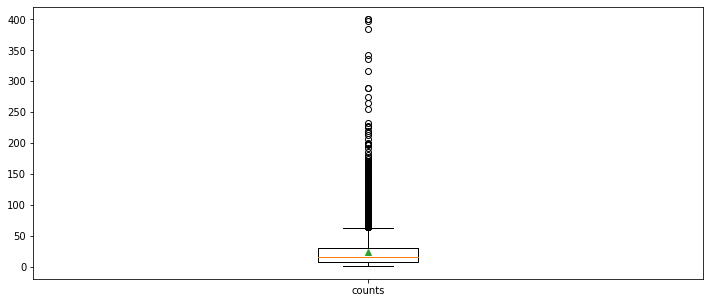

In [7]:
plt.figure(figsize=(12,5))
plt.boxplot(cmt_length, labels=['counts'], showmeans=True)

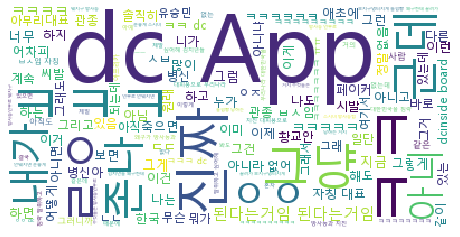

In [8]:
path = 'c:/Windows/Fonts/malgun.ttf'

train_cmt = [cmt for cmt in df_union['cmt_contents'] if type(cmt) is str]
wordcloud = WordCloud(font_path=path,
                      relative_scaling=0.5,
                      background_color = 'white').generate(' '.join(train_cmt))
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

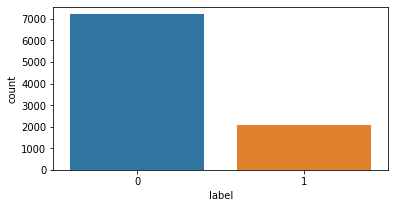

In [9]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(df_union['label'])

In [10]:
print('욕설 댓글 개수', df_union['label'].value_counts()[1])
print('욕설이 아닌 댓글 개수', df_union['label'].value_counts()[0])

욕설 댓글 개수 2089
욕설이 아닌 댓글 개수 7199


Text(0.5, 0, 'Number of comments')

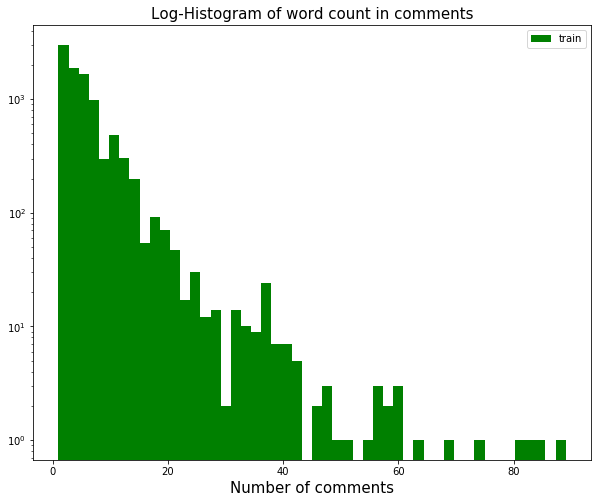

In [11]:
word_counts = df_union['cmt_contents'].astype(str).apply(lambda x:len(x.split(' ')))

plt.figure(figsize=(10, 8))
plt.hist(word_counts, bins=50, facecolor='g', label='train')
plt.title('Log-Histogram of word count in comments', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.xlabel('Number of comments', fontsize=15)

In [12]:
print('댓글 단어 개수 최댓값 ', np.max(word_counts))
print('댓글 단어 개수 최솟값 ', np.min(word_counts))
print('댓글 단어 개수 평균값 ', np.mean(word_counts))
print('댓글 단어 개수 표준편차 ', np.std(word_counts))
print('댓글 단어 개수 중간값 ', np.median(word_counts))
print('댓글 단어 개수 제1사분위 ', np.percentile(word_counts, 25))
print('댓글 단어 개수 제3사분위 ', np.percentile(word_counts, 75))

댓글 단어 개수 최댓값  89
댓글 단어 개수 최솟값  1
댓글 단어 개수 평균값  5.636843238587424
댓글 단어 개수 표준편차  5.973906729359337
댓글 단어 개수 중간값  4.0
댓글 단어 개수 제1사분위  2.0
댓글 단어 개수 제3사분위  7.0


## - 데이터 전처리

In [13]:
def preprocessing(data, mecab, remove_stopwords=False, stop_words=[]):
    data_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", data)
    words = mecab.morphs(data_text)    
    if remove_stopwords:
        words = [token for token in words]

    return words

In [14]:
mecab = Mecab()

stop_words = set(['은', '는', '이', '가', '하', '아', '것',
                  '들', '의', '있', '되', '수', '보', '주',
                  '등', '한'])

clean_cmt = []

In [15]:
for review in tqdm_notebook(df_union['cmt_contents']):
    if type(review) == str:
        clean_cmt.append(preprocessing(review, mecab, remove_stopwords=True,
                                                stop_words=stop_words))
    else:
        clean_cmt.append([])

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_cmt)
train_sequences = tokenizer.texts_to_sequences(clean_cmt)
word_vocab = tokenizer.word_index

In [17]:
MAX_SEQUENCE_LENGTH = 12

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(df_union['label'])

In [18]:
data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

# 학습데이터 벡터화 및 라벨
np.save(open('./data/word_dict/input.npy', 'wb'), train_inputs)
np.save(open('./data/word_dict/label.npy', 'wb'), train_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open('./data/word_dict/data_configs.json', 'w', -1, "utf-8"), ensure_ascii=False)

## 형태소 정보 추가 

In [19]:
from konlpy.tag import Okt
#mecab = Mecab()

def tokenize(doc):
    return ['/'.join(t) for t in okt.pos(doc)]
    #return ['/'.join(t) for t in mecab.pos(doc)]

In [20]:
print(len(df_union))
print(df_union.iloc[1, 1])
print(df_union.iloc[1, -1])

9288
댓글 지우지?
0


In [21]:
def pos_preprocessing(data, okt, remove_stopwords=False, stop_words=[]):
    data_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", data)
    #words = mecab.morphs(data_text)
    words = tokenize(data_text)
    if remove_stopwords:
        words = [token for token in words]

    return words

In [22]:
#mecab = Mecab()
okt = Okt()

stop_words = set(['은', '는', '이', '가', '하', '아', '것',
                  '들', '의', '있', '되', '수', '보', '주',
                  '등', '한'])

docs = []

for review in tqdm_notebook(df_union['cmt_contents']):
    if type(review) == str:
        docs.append(pos_preprocessing(review, okt, remove_stopwords=False,
                                                stop_words=stop_words))
    else:
        docs.append([])

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)
C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)
train_sequences = tokenizer.texts_to_sequences(docs)
word_vocab = tokenizer.word_index

In [24]:
MAX_SEQUENCE_LENGTH = 12

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(df_union['label'])

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

# 학습데이터 벡터화 및 라벨
np.save(open('./data/word_dict/pos_input.npy', 'wb'), train_inputs)
np.save(open('./data/word_dict/pos_label.npy', 'wb'), train_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open('./data/word_dict/pos_data_configs.json', 'w', -1, "utf-8"), ensure_ascii=False)

In [25]:
docs

[['ㅠㅠ/KoreanParticle'],
 ['댓글/Noun', '지우지/Verb'],
 ['ㅋㅋ/KoreanParticle'],
 ['설렁설렁/Adverb', '해/Noun', '라/Josa'],
 ['함/Noun', '묵으라/Verb'],
 ['자지마라/Verb'],
 ['피부/Noun', '원툴/Noun'],
 ['야리/Adjective', '둡/Verb', '후덕/Noun', '해졌노/Verb', 'ㅋㅋ/KoreanParticle'],
 ['피부/Noun', '도르/Verb', '수상/Noun', 'ㅋㅋㅋ/KoreanParticle'],
 ['왜/Noun',
  '냐/Josa',
  '즈그/Noun',
  '아들/Noun',
  '딸/Noun',
  '들/Suffix',
  '은/Josa',
  '이미/Adverb',
  '졸업/Noun',
  '했기/Verb',
  '때문/Noun'],
 ['ㅇㅈ/KoreanParticle', 'ㅋㅋㅋㅋㅋ/KoreanParticle', '리얼/Noun', '재앙/Noun'],
 ['퍄퍄/Noun', '내향성/Noun', '갤러리/Noun', 'ㄱㄱ/KoreanParticle'],
 ['ㅋㅋㅋㅋㅋ/KoreanParticle', '시발/Noun'],
 ['남자/Noun',
  '새끼/Noun',
  '지인/Noun',
  '인데/Josa',
  '도/Noun',
  '그냥/Noun',
  '도망가네/Verb'],
 ['시발/Noun', '새끼/Noun'],
 ['시발련/Noun', '아/Josa'],
 ['나은/Noun', '아씨/Noun', '는/Josa', 'ㅇㅈ/KoreanParticle', '이지/Noun'],
 ['노잼/Noun'],
 [],
 ['ㅋㅋㅋ/KoreanParticle'],
 ['지랄/Noun', 'ㅋㅋ/KoreanParticle'],
 ['퍄/Noun'],
 ['그걸/Adverb', '왜/Noun', '붙여/Verb', 'ㅋㅋㅋㅋㅋ/KoreanParticle'],
 ['ㄹㅇ/KoreanPartic

In [26]:
data_configs

{'vocab': {'이/josa': 1,
  '가/josa': 2,
  '에/josa': 3,
  '도/josa': 4,
  '들/suffix': 5,
  '은/josa': 6,
  '는/josa': 7,
  'ㅋㅋ/koreanparticle': 8,
  '을/josa': 9,
  'ㅋㅋㅋ/koreanparticle': 10,
  '임/noun': 11,
  '로/josa': 12,
  '안/verbprefix': 13,
  '새끼/noun': 14,
  '이/determiner': 15,
  '다/adverb': 16,
  '으로/josa': 17,
  '진짜/noun': 18,
  '못/verbprefix': 19,
  '거/noun': 20,
  '야/josa': 21,
  '에서/josa': 22,
  '를/josa': 23,
  'ㄹㅇ/koreanparticle': 24,
  '고/josa': 25,
  '만/josa': 26,
  '병신/noun': 27,
  '내/noun': 28,
  '왜/noun': 29,
  '아/josa': 30,
  '의/josa': 31,
  '말/noun': 32,
  '존나/noun': 33,
  '지/josa': 34,
  '면/josa': 35,
  '뭐/noun': 36,
  'ㅇㅇ/koreanparticle': 37,
  '인데/josa': 38,
  '하고/josa': 39,
  '한/determiner': 40,
  'ㅋㅋㅋㅋ/koreanparticle': 41,
  '그냥/noun': 42,
  '더/noun': 43,
  '근데/adverb': 44,
  '아/exclamation': 45,
  '개/noun': 46,
  '냐/josa': 47,
  '나/josa': 48,
  '좀/noun': 49,
  '애/noun': 50,
  '때/noun': 51,
  '하는/verb': 52,
  '안/noun': 53,
  '너/noun': 54,
  '나/noun': 55,
  '한테/josa': 5